RNN_Quest_1: We will implement a pretrained RNN_Model and classify some artwork! After all, this is more fun than looking at welding seems or lung cancer data. 

You can download the data from: 

https://www.kaggle.com/ikarus777/best-artworks-of-all-time?select=artists.csv

Now only select the data in images of the following painters:

- Rembrandt
- Dürer
- Leonardo da Vinci
- Caravaggio 
- de Bongione 

These are required - if you want, you can also add others, like

- Michelangelo 

- Raffael

and even more. Just make sure that they are from sort of the same time and hence have a similar style. It's pretty easy to distinguish a Rembrandt from an Andy Warhol.

After you have done that, put the images into a data structure like in the Live-Coding last week. You can do that with the script from then (altered of course) - or just do it by hand. But please do not split into Train, Validation and Test set by hand. Use sklearn or any other method to randomly sample the images of each folder into the three sets. 




### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from google.colab import drive
drive.mount('/content/drive')

### Data Collection 

In [ ]:
# load the images
%cd /content/
!mkdir local_all
!unzip '/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest/RNN_Quest.zip' -d local_all

In [4]:
# create directory strucuture for flow_gen
%cd /content/
!mkdir local_split
%cd /content/local_split/
!mkdir training_set
!mkdir test_set

/content
/content/local_split


In [5]:
# get paths of images 

all_paths = []
y_class = []
for x in os.listdir('/content/local_all/RNN_Quest'): 
  path = '/content/local_all/RNN_Quest/' + x
  for y in os.listdir(path):
   all_paths.append('/content/local_all/RNN_Quest/' + x + '/' + y)
   y_class.append(x)
   

   
  

In [6]:
# split in train and test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_paths, y_class, test_size=0.2, random_state=42)

 

In [7]:
# create class directory 
for element in set(y_train):
  path = '/content/local_split/training_set/' + element
  os.mkdir(path)

for element in set(y_train):
  path = '/content/local_split/test_set/' + element
  os.mkdir(path)

import shutil

# copy our images into the new train/test structure 
for element in X_train: 
  source = element
  destination = '/content/local_split/training_set/' + element.split("/")[4]
  shutil.copy2(source, destination)
  

for element in X_test: 
  source = element
  destination = '/content/local_split/test_set/' + element.split("/")[4]
  shutil.copy2(source, destination)


Now explore the data. 

- What are the different image dimensions?

- How are the labels distributed?

- What else would be useful to know?

In [ ]:
# different image dimensions: 
import numpy as np
import cv2

dimensions = []
for image in X_train: 
 img = cv2.imread(image)
 dimensions.append(img.shape)

print(set(dimensions))
print('There are: ', len(set(dimensions)) , 'different image dimensions')

In [9]:
from collections import Counter
print('Label Distribution:')
Counter(y_train)

Label Distribution:


Counter({'Albrecht_Duerer': 272,
         'Caravaggio': 46,
         'Giotto_di_Bondone': 91,
         'Leonardo_da_Vinci': 113,
         'Michelangelo': 43,
         'Raphael': 81,
         'Rembrandt': 206})

What is the most obvious way to deal with this data?

Think a bit about it. 

Correct: We just resize all images to the same size! In this case to a dimension which can easily be used in a Resnet50 or a VGG_16 or VGG_19, i.e. 224 x 224 You do not have to code this here, as the data generator will do it for us (at least if you use the same one as last week). 

Now set up the data generator - and test it. 


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# i was very gentle with the ImageDataGenerator, because I thought an artists knows what he wants to draw..and what not.    

train_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=None,
    shear_range=5.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,
    dtype=None,
)

test_gen = ImageDataGenerator(rescale=1./255.)

In [11]:
batch_size = 16

# get the images (train, validation and test set) into the generator

train_batches = train_gen.flow_from_directory(
        directory='/content/local_split/training_set',
        target_size=(224, 224),
        shuffle = False,
        subset = 'training',
        batch_size = batch_size,
        class_mode='sparse')

val_batches = train_gen.flow_from_directory(
    directory='/content/local_split/training_set',
    target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse',
    subset='validation'
    )

test_batches = test_gen.flow_from_directory(
        directory='/content/local_split/test_set',
        target_size=(224, 224),
        batch_size = batch_size,
        shuffle=False,
        class_mode='sparse')

Found 684 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
Found 213 images belonging to 7 classes.


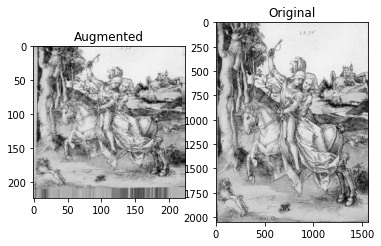

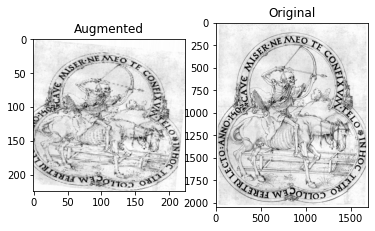

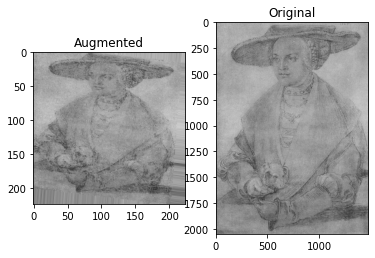

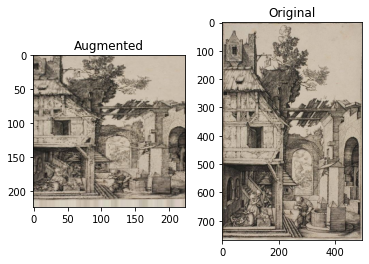

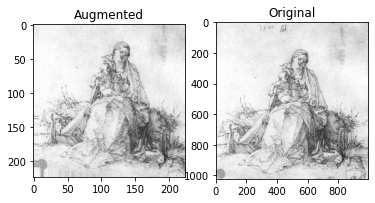

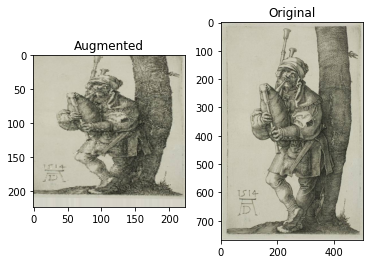

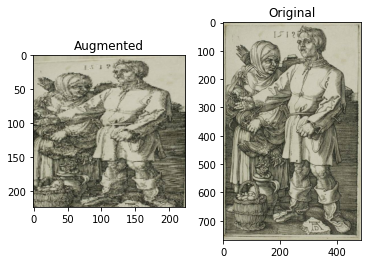

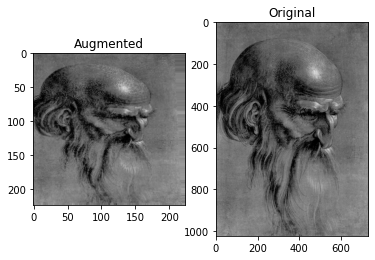

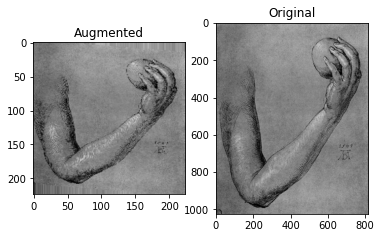

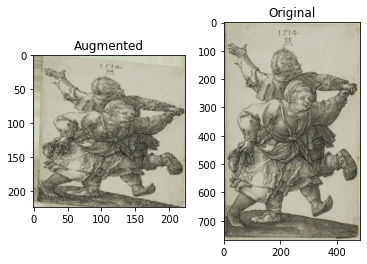

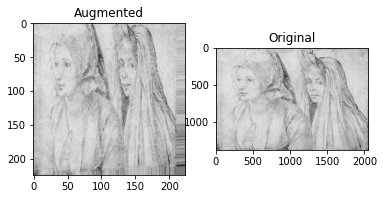

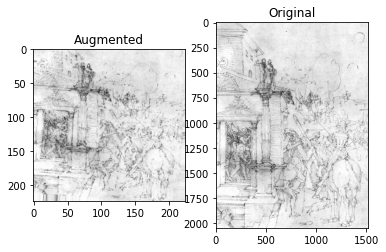

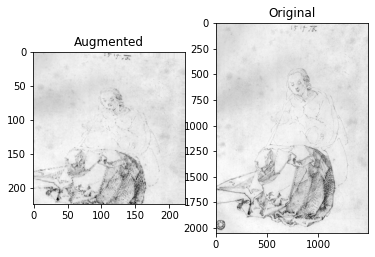

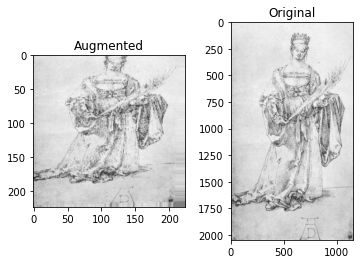

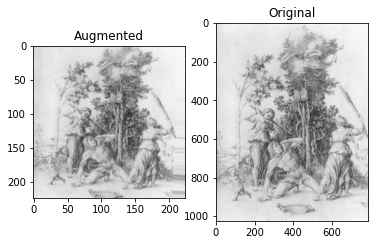

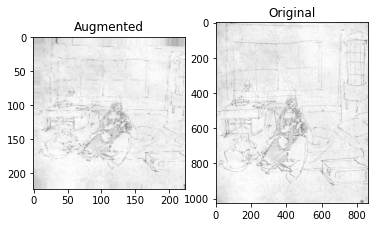

In [12]:


# =============================================================================
# Test train_generator (to visualize augmentations performed) 
# =============================================================================
train_dir = '/content/local_split/training_set'

data_batch = train_batches.next()
imgs = data_batch[0]
labels = data_batch[1]

# Der Generator merkt sich die Filenames aus dem flow_from_directory !!

orig_img_fn_list = train_batches.filenames
for i in range(batch_size):
    
    img = imgs[i]
    orig_img = plt.imread(train_dir + '/' + orig_img_fn_list[i])
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[0].set_title('Augmented')
    ax[1].imshow(orig_img)
    ax[1].set_title('Original')
    plt.show()

 

Now set up a Resnet50 and a VGG_19 (or another model for comparison), pretrained on Imagenet - and write a new custom top-layer to match the number of classes you've chosen. 

In [13]:
# load vgg19, keep all the weights
from tensorflow.keras.applications.vgg19 import VGG19
vgg19_model = VGG19(include_top=False, input_shape=(224, 224, 3))
vgg19_model.trainable = False


80142336/80134624 [==============================] - 1s 0us/step


In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# custom Classifier for vgg19

model_vgg19 = Sequential()
model_vgg19.add(Flatten(input_shape=(7, 7, 512)))
model_vgg19.add(Dense(1024, activation="relu"))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.3))
model_vgg19.add(Dense(64, activation='relu'))

model_vgg19.add(Dense(7, activation='softmax'))


In [15]:
# load restnet50, keep all the weights
from tensorflow.keras.applications.resnet50 import ResNet50
re50_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
re50_model.trainable = False



94773248/94765736 [==============================] - 1s 0us/step


In [16]:
re50_model.output_shape

(None, 7, 7, 2048)

In [17]:
# custom Classifier for restnet50
model_re50 = Sequential()

#model_re50.add(MaxPooling2D(7,7))
model_re50.add(Flatten(input_shape=(7, 7, 2048)))
model_re50.add(Dense(2048, activation="relu"))
model_re50.add(Dropout(0.5))
model_re50.add(Dense(1024, activation='relu'))
model_re50.add(Dropout(0.3))
model_re50.add(Dense(512, activation='relu'))
model_re50.add(Dropout(0.3))
model_re50.add(Dense(64, activation='relu'))
model_re50.add(Flatten())
model_re50.add(Dense(7, activation='softmax'))


Compare both models - which has more parameters?

In [18]:
vgg19_model.count_params()

20024384

In [19]:
re50_model.count_params()

23587712

Compile both models, train both models and evaluate both models on the test set.

In [20]:
# First get a prediction with pretrained and locked model 
train_after_vgg19 = vgg19_model.predict(train_batches, verbose = 1)
train_after_re50 = re50_model.predict(train_batches, verbose = 1)
y_train = train_batches.classes

val_after_vgg19 = vgg19_model.predict(val_batches, verbose = 1)
val_after_re50 = re50_model.predict(val_batches, verbose = 1)
y_val = val_batches.classes

test_after_vgg19 = vgg19_model.predict(test_batches, verbose = 1)
test_after_re50 = re50_model.predict(test_batches, verbose = 1)
y_test = test_batches.classes




14/14 [==============================] - 5s 360ms/step


In [21]:
# compile the custom classifier 

from tensorflow.keras.optimizers import Adam
model_vgg19.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

model_re50.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])


In [22]:
# shuffle the 'Pre'-'Predictions'
from sklearn.utils import shuffle

train_after_vgg19,train_after_re50, y_train = shuffle(train_after_vgg19, train_after_re50,y_train)
val_after_vgg19,val_after_re50, y_val = shuffle(val_after_vgg19,val_after_re50, y_val)
#test_after_vgg19,test_after_re50, y_test = shuffle(test_after_vgg19,test_after_re50, y_test)



In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint
#!cd '/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest'
mcp_vgg19 = ModelCheckpoint('best_model_vgg19', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)
mcp_re50 = ModelCheckpoint('best_model_re50', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [31]:
# lets train the new classifier

epochs = 30
batch_size = 32
model_vgg19.fit(x=train_after_vgg19, y = y_train, validation_data= (val_after_vgg19, y_val), epochs=epochs, verbose=1,callbacks=[mcp_vgg19])
model_re50.fit(x=train_after_re50, y = y_train, validation_data= (val_after_re50, y_val), epochs=epochs, verbose=1,callbacks=[mcp_re50])

#history = model_vgg19.fit(x=train_after_vgg19, y = y_train, validation_data= (test_after_vgg19, y_test), epochs=epochs, batch_size= batch_size, verbose=1, callbacks=[mcp])


Epoch 1/30
22/22 [==============================] - 1s 28ms/step - loss: 1.9088 - accuracy: 0.2901 - val_loss: 1.3012 - val_accuracy: 0.5833

Epoch 00001: val_accuracy improved from -inf to 0.58333, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 1.4429 - accuracy: 0.4982 - val_loss: 1.0745 - val_accuracy: 0.6310

Epoch 00002: val_accuracy improved from 0.58333 to 0.63095, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 1.1393 - accuracy: 0.5792 - val_loss: 0.9911 - val_accuracy: 0.6548

Epoch 00003: val_accuracy improved from 0.63095 to 0.65476, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 0.9289 - accuracy: 0.6696 - val_loss: 0.9124 - v

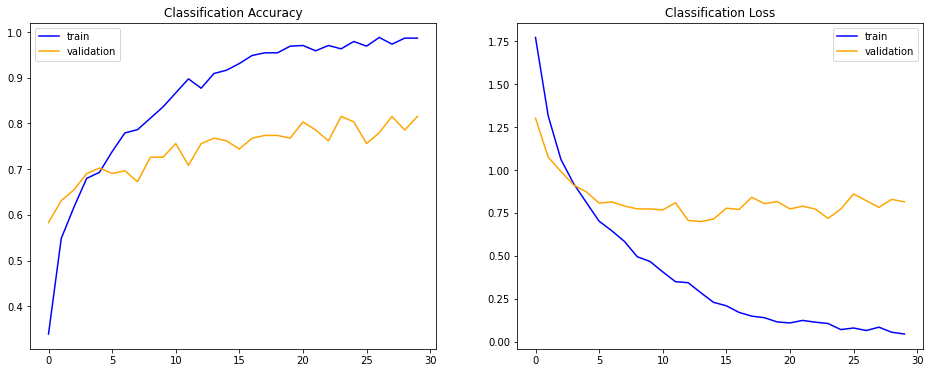

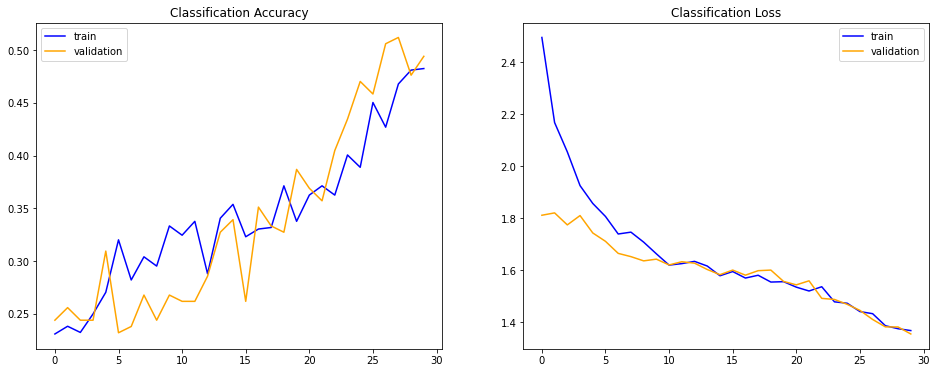

In [32]:
from tensorflow.python.keras.callbacks import History

def plot_training_history(history: History):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Classification Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.legend()

  plt.show()

plot_training_history(model_vgg19.history)
plot_training_history(model_re50.history)

In [33]:
from keras.models import load_model
best_model_vgg19 = load_model('best_model_vgg19')

best_model_vgg19.evaluate(test_after_vgg19, y_test)

7/7 [==============================] - 1s 5ms/step - loss: 0.5573 - accuracy: 0.8263


[0.5573122501373291, 0.8262910842895508]

In [34]:
from keras.models import load_model
best_model_re50 = load_model('best_model_re50')

best_model_re50.evaluate(test_after_re50, y_test)

7/7 [==============================] - 0s 12ms/step - loss: 1.3689 - accuracy: 0.5164


[1.3688510656356812, 0.5164319276809692]

Now try to tune the hyperparameters, including

*   Optimizer
*   Data Augmentation (look at what keras has under the hood)



Have you checked how "good" or "bad" the model performs for different painters? 

Just implement a function that gives you the accuracy and/or other metric for each class. 

Plot the class size vs. the accuracy (and or other metrics)

In [35]:
classes_to_int = {
  'Duerer':0,
  'Caravaggio':1,
  'Di_Bondone':2,
  'Da_Vinci':3,
  'Michelangelo':4,
  'Raphael':5,
  'Rembrandt':6
}

int_to_classes = {value:key for key, value in classes_to_int.items()}

y_test_translated = []
for i in y_test:
 y_test_translated.append(int_to_classes[i])


In [36]:
y_pred_vgg19 = np.argmax(best_model_vgg19.predict(test_after_vgg19), axis = 1)

y_test_pred_vgg19_translated = []
for i in y_pred_vgg19:
 y_test_pred_vgg19_translated.append(int_to_classes[i])


y_pred_re50 = np.argmax(best_model_re50.predict(test_after_re50), axis = 1)

y_test_pred_re50_translated = []
for i in y_pred_re50:
 y_test_pred_re50_translated.append(int_to_classes[i])

In [ ]:
#### old way, not exactly accuracy because True Negatives are not consindered: 
#from sklearn.metrics import confusion_matrix

#matrix_vgg19 = confusion_matrix(y_test_translated, y_test_pred_vgg19_translated)
#vgg_19_accuracies_per_class = matrix_vgg19.diagonal()/matrix_vgg19.sum(axis=1)

#matrix_re50 = confusion_matrix(y_test_translated, y_test_pred_re50_translated)
#re50_accuracies_per_class = matrix_re50.diagonal()/matrix_re50.sum(axis=1)

In [37]:
from sklearn.metrics import confusion_matrix
# after Discussion with Peter: 

def get_accuracy_by_class(y_true, y_pred, classes):
  ### Stolen from https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
  ### Accurac = TP + TN / (TP + TN + FP + FN)
  # Get the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # We will store the results in a dictionary for easy access later
  per_class_accuracies = {}

  # Calculate the accuracy for each one of our classes
  for idx, cls in enumerate(classes):
    # True negatives are all the samples that are not our current class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
  
  return per_class_accuracies

In [38]:
vgg_19_accuracies_per_class = get_accuracy_by_class(y_test_translated, y_test_pred_vgg19_translated, classes_to_int.values())

re50_accuracies_per_class = get_accuracy_by_class(y_test_translated, y_test_pred_re50_translated, classes_to_int.values())


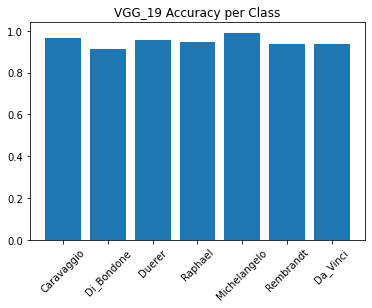

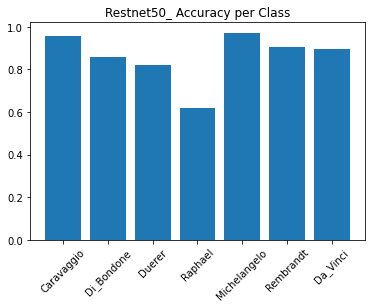

In [39]:
import matplotlib.pyplot as plt
plt.bar(x = list(set(y_test_translated)), height = vgg_19_accuracies_per_class.values())
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=45)
plt.show()


plt.bar(x = list(set(y_test_translated)), height = re50_accuracies_per_class.values())
plt.title('Restnet50_ Accuracy per Class')
plt.xticks(rotation=45)
plt.show()


# Restnet 50 Manual Approach (train restnet50 manually):



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 15 10:28:32 2021

@author: wolfg
"""

# =============================================================================
# Imports
# =============================================================================

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, AveragePooling2D, Conv2D
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import Callback


from tensorflow.keras.applications.resnet50 import ResNet50

import numpy as np

# =============================================================================
# Paths and Variables
# =============================================================================

dropout_rate = 0.4
num_classes = 7
in_shape = (224,224,3)

# =============================================================================
# Top Model
# =============================================================================

a = Input(shape=(7,7,2048))
#x = AveragePooling2D((7,7), name='avg_pool_1')(a)
x = Flatten()(x)
x = Dropout(dropout_rate)(x)
x = Dense(2048, \
          kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), \
          activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(1024, \
          kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), \
          activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, \
          kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), \
          activation='relu')(x)
x = Dense(num_classes, kernel_initializer=initializers.he_normal(), \
          bias_initializer=initializers.ones(), activation='softmax')(x)
top_model = Model(inputs=a, outputs=x)

top_model.summary()

# =============================================================================
# Load resnet50
# =============================================================================

resnet50 = ResNet50(include_top=False, \
                        input_shape=in_shape)
resnet50.trainable = True
resnet50.summary()

# =============================================================================
# Build custom model based on resnet50
# =============================================================================

inp = Input(shape=in_shape)
y = resnet50(inp)
y = top_model(y)
final_model = Model(inputs=inp, outputs=y)
final_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 7, 7, 2048)]      0         
_________________________________________________________________
avg_pool_1 (AveragePooling2D (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 14343     
Total params: 4,210,695
Trainable params: 4,210,695
Non-trainable params: 0
_________________________________________________

In [ ]:
epochs = 25
batch_size = 32


final_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

X_train, y_train
final_model.fit(train_batches, validation_data= (val_batches), epochs=epochs, verbose=1)

Epoch 1/25
43/43 [==============================] - 42s 843ms/step - loss: 0.0879 - accuracy: 0.9740 - val_loss: 2.8797 - val_accuracy: 0.3114
Epoch 2/25
43/43 [==============================] - 35s 816ms/step - loss: 0.1345 - accuracy: 0.9634 - val_loss: 3.6193 - val_accuracy: 0.4012
Epoch 3/25
43/43 [==============================] - 35s 820ms/step - loss: 0.4886 - accuracy: 0.9268 - val_loss: 3.3474 - val_accuracy: 0.2754
Epoch 4/25
43/43 [==============================] - 35s 821ms/step - loss: 0.0436 - accuracy: 0.9857 - val_loss: 4.8510 - val_accuracy: 0.1437
Epoch 5/25
43/43 [==============================] - 35s 825ms/step - loss: 0.1204 - accuracy: 0.9648 - val_loss: 5.0128 - val_accuracy: 0.3353
Epoch 6/25
43/43 [==============================] - 35s 825ms/step - loss: 0.0644 - accuracy: 0.9813 - val_loss: 3.7041 - val_accuracy: 0.4611
Epoch 7/25
43/43 [==============================] - 35s 819ms/step - loss: 0.0747 - accuracy: 0.9806 - val_loss: 3.7898 - val_accuracy: 0.5090

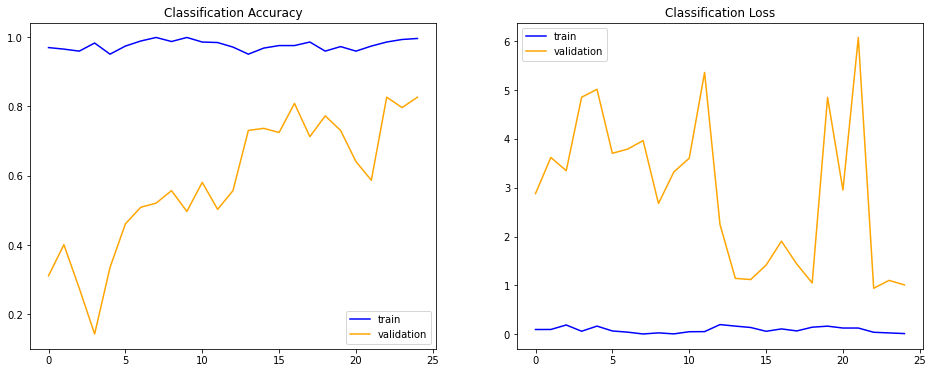

In [ ]:
plot_training_history(final_model.history)

In [ ]:
final_model.evaluate(test_batches)

14/14 [==============================] - 5s 364ms/step - loss: 1.3156 - accuracy: 0.8169


[1.315617561340332, 0.8169013857841492]